In [9]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import scipy 
from scipy.signal import find_peaks

from matplotlib import colors
from matplotlib import ticker

In [ ]:
def get_channel(runNo = 24100, ch = 10, dir = "../coldbox_data/"):
    filename = dir + f"adc_data_run_{runNo}_ch_{ch}_all.npy"
    dat = np.load(filename, allow_pickle=True)
    dat = dat.astype(np.int16) # else it's numpy.int64
    return dat

def subtract_pedestal(channel):
    # np.bincount(channel[0])[6980]
    #     returns number of entries in the bin 6980  [counts the occurrences of each integer value in the array]
    # np.argmax(np.bincount(channel[i])): 
    #     returns the value of the most populated bin for event i
    peds = np.array([np.argmax(np.bincount(channel[i])) for i in range(len(channel))])
    peds = peds[:, np.newaxis] # reshaping, eg. array([1500, 1631, 1483]) -> array([[1500], [1631], [1483]])
    return channel - peds, peds

def find_waveforms(data, peaks, peak_heights, threshold=0.1, nTT_left=10, verbose=False, win_min=0, win_max=0, sat_level=15000):
    """ 
      isolate the waveform using peak heights
      threshold (between 0 and 1): value above (below) which the left (right) window is selected
      special cases:
       sometimes the rise time is very sharp (smaller than 1 time tick), in that case, we need to adapt the strategy
        nTT_left: the begining of the window on the left will be peak position - nTT_left
        -> not sure nTT is still useful
       
      win_max, win_min: max boundaries within which the waveform is searched for, if 0 is provided, then there are no limits
      sat_level: number of ADC above which there is saturation (waveforms containing values above these are thrown away)
    """
    ### left, right and peak correspond to the original position of the peak and window i
    dic = {'idx': [], 'left': [], 'right': [], 'peak': [], 'waveform': [],
           'peak_original': [], 'left_original': [], 'right_original': []}

    for i in range(0, len(peaks)):
        peak10 = peak_heights[i]*threshold

        if win_min==0 and win_max==0:
            ## take abs diff -> 0 corresponds to exactly 10% (if threshold = 0.1), if not 0, then the minim(a) correspond to the closest values
            difference_array = np.absolute(data-peak10)
            ## get indices of the minima
            indices = np.array(np.where( difference_array == difference_array.min() ))[0] ## where() returns a tuple, need to cast into np.array
            ## select the left and right indices (w.r.t the peak position)
            left_indices  = indices[ np.where(indices < peaks[i]) ] 
            if np.any(left_indices)==False: 
                left_indices = [peaks[i]-nTT_left]
            right_indices = indices[ np.where(indices > peaks[i]) ] 
            if np.any(left_indices):  
                left  = left_indices[-1]
                # dic['left'].append(left)
            else: 
                left  = np.nan
                # dic['left'].append(np.nan)
            if np.any(right_indices): 
                right = right_indices[0]
                # dic['right'].append(right)
            else: 
                right = np.nan
                # dic['right'].append(np.nan)
        else:
            l = peaks[i]-win_min
            r = peaks[i]+win_max
            difference_array = np.absolute(data[l:r]-peak10)
            indices = np.array(np.where( difference_array == difference_array.min() ))[0]+l
            left_indices  = indices[ np.where(indices < peaks[i]) ] 
            right_indices = indices[ np.where(indices > peaks[i]) ] 
            
            if np.any(left_indices):
                left  = left_indices[-1]
            else:
                left = l
            
            if np.any(right_indices): 
                right = right_indices[0]
            else:
                right = r

        ## save waveform
        wf = data[left:right]
        if np.all(wf<sat_level):
            dic['idx'].append(i)
            dic['peak_original'].append(peaks[i])
            dic['left_original'].append(left)
            dic['right_original'].append(right)

            dic['peak'].append(win_min)
            dic['left'].append(0)
            dic['right'].append(win_max - win_min)

            dic['waveform'].append(wf)

        

        if verbose:
            print()
            print(f'peaks[{i}] = {peaks[i]}, 10% of peak = {peak10}')
            if (win_min!=0 and win_max!=0): print(f'look around the peak ({l}, {r})')
            print('indices', indices)
            if np.any(left_indices):  print('left_indices',  left_indices)
            if np.any(right_indices): print('right_indices', right_indices)
            l_txt, r_txt = '', ''
            if np.any(left_indices):  l_txt = f'left = {left}' 
            if np.any(right_indices): r_txt = f'right = {right}'
            print(f'position of the min closest to peak, {l_txt}, {r_txt}')

    return dic


## to make things easier
def get_waveforms(data, threshold=0.1, nTT_left=10, verbose=False, win_min=50, win_max=400, sat_level=14500):
    peaks, heights = find_peaks(data, height=1000, distance=150, prominence = 100, plateau_size = 0)
    peaks_tot = len(peaks)
    mask = heights['plateau_sizes'] < 2
    peak_heights = heights['peak_heights'][mask]
    peaks = peaks[np.where(mask)]
    peaks_NoSat = len(peaks)
    print(f'found {peaks_tot} peaks, after removing saturated peaks: {peaks_NoSat} (-> {peaks_tot - peaks_NoSat} with saturated peaks) ')
    d = find_waveforms(data, peaks, peak_heights, threshold, nTT_left, verbose, win_min, win_max, sat_level)
    print(f'{len(d["idx"])} waveforms saved')
    return d


In [11]:
# neutrons
n = get_channel(runNo = 25036, ch = 40)
n = n[:, 3000:6000].copy()
print(f'shape: {n.shape}')
n, peds_n = subtract_pedestal(n)

shape: (16600, 3000)


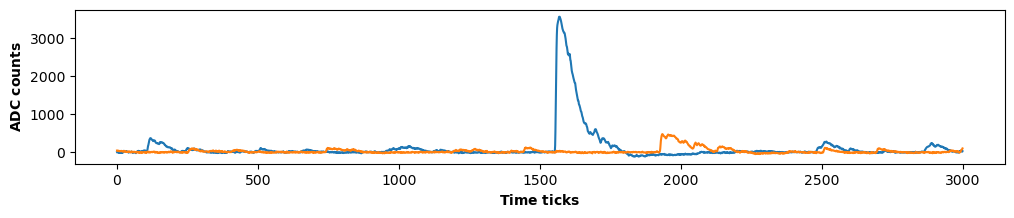

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(12, 2))
axs.plot(n[0:2].transpose())
axs.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
axs.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");


# Extract waveforms

In [5]:
n = n.flatten()
print(f' final shape: {n.shape}')

 final shape: (49800000,)


In [6]:
neutrons = get_waveforms(n, threshold=0.1, nTT_left=10, verbose=False, win_min=50, win_max=400, sat_level=14500)

found 1828 peaks, after removing saturated peaks: 1717 (-> 111 with saturated peaks) 
1715 waveforms saved


In [7]:
neutrons.keys()

dict_keys(['idx', 'left', 'right', 'peak', 'waveform', 'peak_original', 'left_original', 'right_original'])

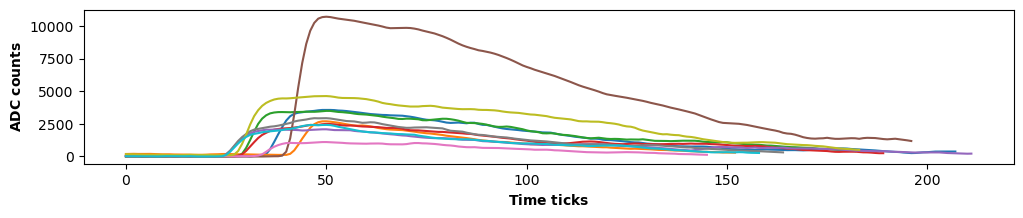

In [8]:
# plot first 10 waveforms
fig, axs = plt.subplots(1, 1, figsize=(12, 2))
for w in neutrons['waveform'][:10]:
    axs.plot(w)
axs.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
axs.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");

array([0, 2, 0, 1, 0, 0, 0, 0, 3])